# Assigment 3


## Upload your code on Learn dropbox and submit pdfs of the code and answers to the mathematical questions on Crowdmark.

## -----------------------------------------------------------------------------------------------------------

## Load modules

In [241]:
# !pip install numpy, scipy, scikit-image, skimage, matplotlib

import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage import data
from skimage.transform import resize

# Numpy is useful for handling arrays and matrices.
import numpy as np

## Load image

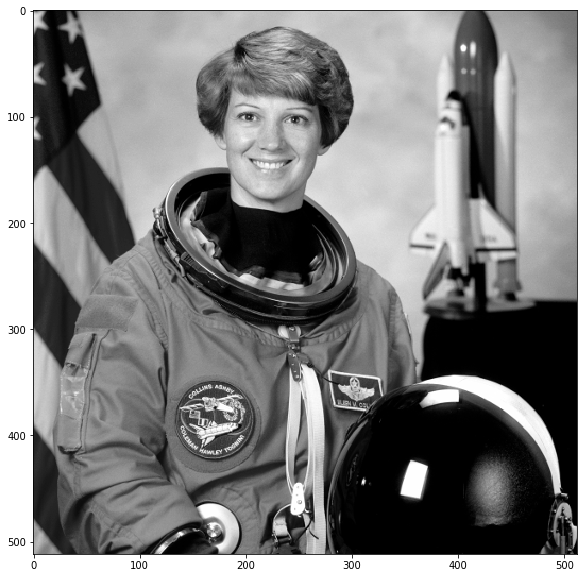

In [242]:
img = data.astronaut()
img = rgb2gray(img)*255 # convert to gray and change scale from (0,1) to (0,255).

n = img.shape[0]

plt.figure(1, figsize=(10, 10))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

## Compute the differences operators here. Use your code from Assignment 2.

In [243]:
# You will need these three methods to construct sparse differences operators.
# If you do not use sparse operators you might have scalability problems.
from scipy.sparse import diags
from scipy.sparse import kron
from scipy.sparse import identity
from scipy.linalg import norm
import math
import time

# Use your code from Assignment 2. 
# Make sure that you compute the right D_h and D_v matrices.
diagonals = ([-1],[1])
j = diags(diagonals, [0,1], shape=(n,n), format=None, dtype=int)
i = np.identity(n)
d_h = kron(j,i)
d_v = kron(i,j)

## Add noise to the image

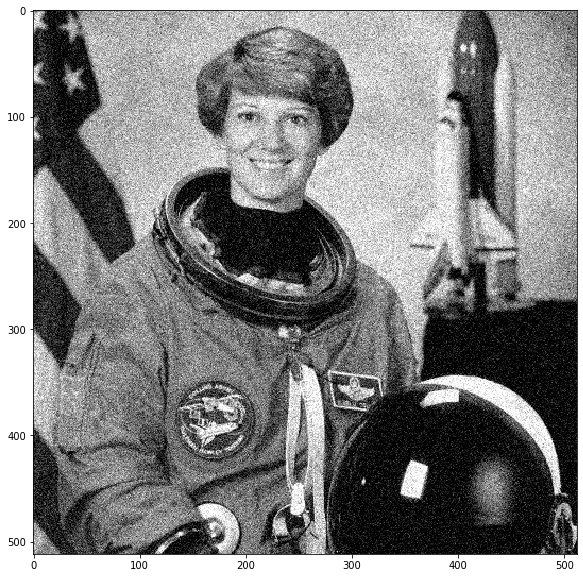

In [244]:
mean_ = 0
standard_deviation = 30
dimensions = (n,n)

noise = np.random.normal(mean_,standard_deviation,dimensions)

noisy_image = img + noise

plt.figure(1, figsize=(10, 10))
plt.imshow(noisy_image, cmap='gray', vmin=0, vmax=255)
plt.show()

## Question 1 (8 marks): implement gradient descent with Armijo line-search for the Total-Variation denoising problem. Use the pseudo-Huber function to smooth the problem. 

In [259]:
# Write your code here.
D = d_h + 1j * d_v
D_star = D.conjugate().transpose()
lambda_ = 25
epsilon = 1.0e-2
max_iterations = 100
gamma = 0.3
miu = 1
z_noisy = noisy_image.flatten('F')

#defining the pseudo-huber function and the total variation denoising
def smooth_total_variation(x, miu, lambda_, z_noisy):
    Dx = D.dot(x)
    huber = np.sum(np.sqrt(miu**2+abs(Dx)**2) - miu)
    huber = lambda_*huber + 1/2*norm(x-z_noisy, 2)**2
    return huber

# getting the partial derivative, the gradient
def gradient_stv(x, miu, lambda_, z_noisy):
    Dx = D.dot(x)
    denom = 1/(d_h.dot(x)**2 + d_v.dot(x)**2 + miu**2)**(0.5)
    partial_der = d_h.transpose().dot(d_h.dot(x)*denom) + d_v.transpose().dot(d_v.dot(x)*denom)
    partial_der = lambda_*partial_der + x - z_noisy
    return partial_der

def line_search_armijo(x, miu, lambda_, gamma, z_noisy):
    alpha = 1
    grad_svt = gradient_stv(x, miu, lambda_, z_noisy)
    svt = smooth_total_variation(x, miu, lambda_, z_noisy)
    
    x_step = x - alpha*grad_svt #step size
    svt_step = smooth_total_variation(x_step, miu, lambda_, z_noisy)
    norm_of_grad = gamma*norm(grad_svt, 2)**2
    svt_k_minus_grad = svt - alpha*norm_of_grad #norm of the gradient, to check for progress inequality
    
    while not svt_step<=svt_k_minus_grad:
        alpha /= 2
        x_step = x - alpha*grad_svt
        svt_step = smooth_total_variation(x_step, miu, lambda_, z_noisy)
        svt_k_minus_grad = svt - alpha*norm_of_grad
    return alpha
    
def gradient_descent(x0, epsilon, lambda_, max_iterations, gamma, miu, z_noisy):
    list_x = []
    x_k = x0
    i=0
    initial_svt = smooth_total_variation(x_k, miu, lambda_, z_noisy)
    list_x.append(initial_svt)
    gradient = gradient_stv(x_k, miu, lambda_, z_noisy)
    
    while i < max_iterations:
        if norm(gradient, 2) <= epsilon: break
#         print("iterations: "+str(i))
        alpha = line_search_armijo(x_k, miu, lambda_, gamma, z_noisy)
        x_k = x_k - alpha*gradient #step size
        list_x.append(smooth_total_variation(x_k, miu, lambda_, z_noisy))
        gradient = gradient_stv(x_k, miu, lambda_, z_noisy)
        i+=1
        
    return x_k, list_x, i

## Call Gradient Descent with Armijo line-search to denoise the image. Parameter tunning is not given for this assignment. You will have to tune all parameters yourself. Regarding the quality of the output image, pick the $\lambda$ parameter that makes the error $$\frac{1}{n^2}\|z_{output} - z_{clean}\|_2$$ as small as possible, where $z_{output}$ is the output of the algorithm. Find $\lambda$ by trial and error. Note that the smoothing parameter $\mu$ affects the quality of the output as well. Pick $\mu$ small enough such that the above error does not improve much for smaller values of $\mu$. I will measure the running time only for your chosen parameters $\lambda$ and $\mu$, therefore, make sure to seperate any code that does trial and error and the code that reports the result for the chosen parameters.

running time: 15.465534925460815


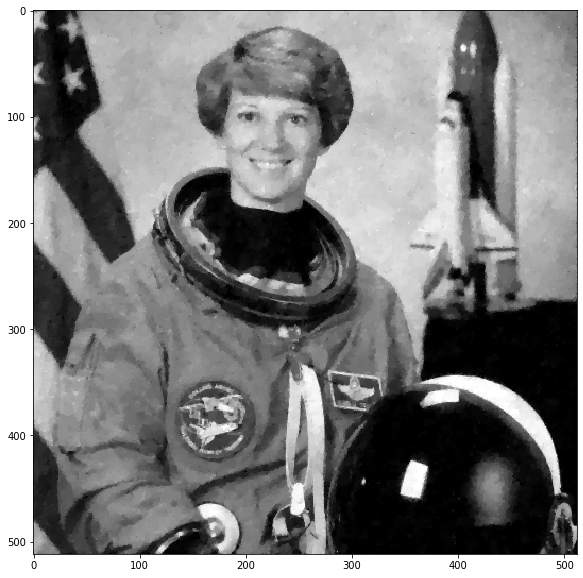

error rate = 0.019539347456879463


In [261]:

start = time.time()

x_min, list_svt_armijo, num_iter = gradient_descent(z_noisy, epsilon, lambda_, max_iterations, gamma, miu, z_noisy)
error = (1/n**2)*norm(x_min-img.flatten('F'),2)

end = time.time()
duration = end-start
print("running time: "+str(duration))

x_min = np.reshape(x_min, (n,n), order="F")
plt.figure(1, figsize=(10, 10))
plt.imshow(x_min, cmap='gray', vmin=0, vmax=255)
plt.show()
print("error rate = "+str(error))

## Question 2 (5 marks): implement gradient descent with simple line-search for the Total-Variation denoising problem. Use the pseudo-Huber function to smooth the problem.

In [263]:
# Write your code here.
def vanilla_line_search(x, lambda_, miu, z_noisy):
    alpha = 1
    grad_svt = gradient_stv(x, miu, lambda_, z_noisy)
    svt = smooth_total_variation(x, miu, lambda_, z_noisy)
    
    x_step = x - alpha*grad_svt #step size
    svt_step = smooth_total_variation(x_step, miu, lambda_, z_noisy)
#     norm_of_grad = gamma*norm(grad_svt, 2)**2
#     svt_k_minus_grad = svt - alpha*norm_of_grad #norm of the gradient, to check for progress inequality

    while svt_step>=svt:
        alpha /= 2
        x_step = x - alpha*grad_svt
        svt_step = smooth_total_variation(x_step, miu, lambda_, z_noisy)
#         svt_k_minus_grad = svt - alpha*norm_of_grad
    return alpha
    
def vanilla_gradient_descent(x0, epsilon, lambda_, max_iterations, miu, z_noisy):
    list_x = []
    x_k = x0
    i=0
    initial_svt = smooth_total_variation(x_k, miu, lambda_, z_noisy)
    list_x.append(initial_svt)
    gradient = gradient_stv(x_k, miu, lambda_, z_noisy)
    
    while i < max_iterations:
        if norm(gradient, 2) <= epsilon: break
#         print("iterations: "+str(i))
        alpha = vanilla_line_search(x_k, lambda_, miu, z_noisy)
        x_k = x_k - alpha*gradient #step size
        list_x.append(smooth_total_variation(x_k, miu, lambda_, z_noisy))
        gradient = gradient_stv(x_k, miu, lambda_, z_noisy)
        i+=1
        

    return x_k, list_x

## Call gradient descent with simple line-search to denoise the image. Use the same $\lambda$ and $\mu$ that you used in Q1. 

running time: 14.723087072372437


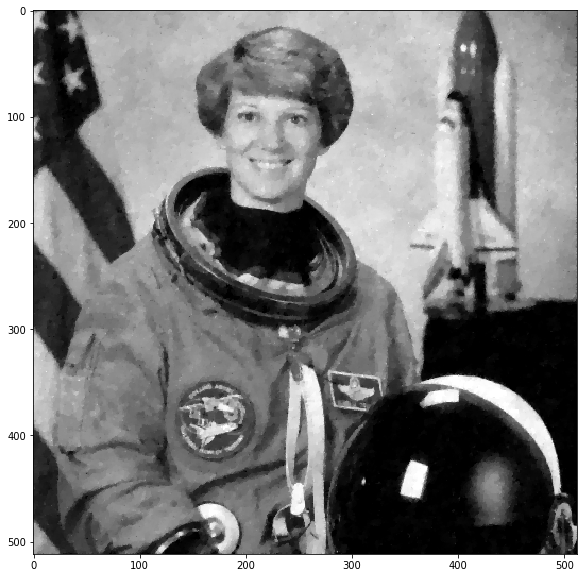

error rate = 0.019558676336798794


In [264]:
# write your code here
start = time.time()
x_min, list_svt_vanilla = vanilla_gradient_descent(z_noisy, epsilon, lambda_, max_iterations, miu, z_noisy)
error = (1/n**2)*norm(x_min-img.flatten('F'),2)
end = time.time()
duration = end-start
print("running time: "+str(duration))

x_min = np.reshape(x_min, (n,n), order="F")
plt.figure(1, figsize=(10, 10))
plt.imshow(x_min, cmap='gray', vmin=0, vmax=255)
plt.show()
print("error rate = "+str(error))

## Question 3 (6 marks): Compute a Lipschitz constant for the smoothed Total-Variation problem. Note the Lipschitz constant is not unique. However, the minimum Lipschitz constant will give you better performance in algorithms compared to larger Lipschitz constants. This means that whatever you compute here will affect the running time of your algorithm in Q4.

In [265]:
from scipy.sparse import vstack
from scipy.sparse.linalg import eigsh

start = time.time()
A = vstack([d_h,d_v])
A_star = np.conjugate(A).transpose()
A2 = A_star.dot(A)
vals = eigsh(A2, k=1, which='LM', return_eigenvectors=False) #largest␣
lip_constant = lambda_*vals[0]/miu + 1
end = time.time()
duration = end-start
print("running time: "+str(duration))
print("L = "+str(lip_constant))

running time: 256.5611479282379
L = 200.99812119956016


## Question 4 (8 marks): implement accelerated gradient for the Total-Variation denoising problem. Use the pseudo-Huber function to smooth the problem. Use the Lipschitz constant that you obtained in Q3. Do not include computation of the Lipschitz constant in this question. You can do it in Q3 and the time for computing the Lipschitz constant will not be taken into account.

In [266]:
def accel_gradient(x0, epsilon, lambda_, max_iterations, miu, lip_c, z_noisy):
    z_kminus1 = x0
    x_kminus1 = x0
    list_x = []
    
    grad_svt = gradient_stv(x_kminus1, miu, lambda_, z_noisy)
    initial_svt = smooth_total_variation(x_kminus1, miu, lambda_, z_noisy)
    list_x.append(initial_svt)
    
    gamma_k = 0
    lambda_k = 1
    i=1
    
    #using pseudo code from lecture 9 notes, 2.2
    while i < max_iterations:
        if norm(grad_svt, 2) <= epsilon: break
            
        if i>=4:
            gamma_k = 2/i
        else:
            gamma_k = 0
        
        y_kminus1 = (1-gamma_k)*x_kminus1 + gamma_k*z_kminus1
        # lecture9, 2.1
        lambda_k = (1-gamma_k)*lambda_k
        delta_y_kminus1 = (1/lip_c)*gradient_stv(y_kminus1, miu, lambda_, z_noisy)
        
        z_kminus1 = z_kminus1 - (gamma_k/lambda_k)*delta_y_kminus1
        x_kminus1 = y_kminus1 - delta_y_kminus1
        
        list_x.append(smooth_total_variation(x_kminus1, miu, lambda_, z_noisy))
#         print("iterations: "+str(i))
        i+=1
        

    return x_kminus1, list_x
    

## Call accelerated gradient to denoise the image. Use the same $\lambda$ and $\mu$ that you used in Q1.

running time: 3.6962890625


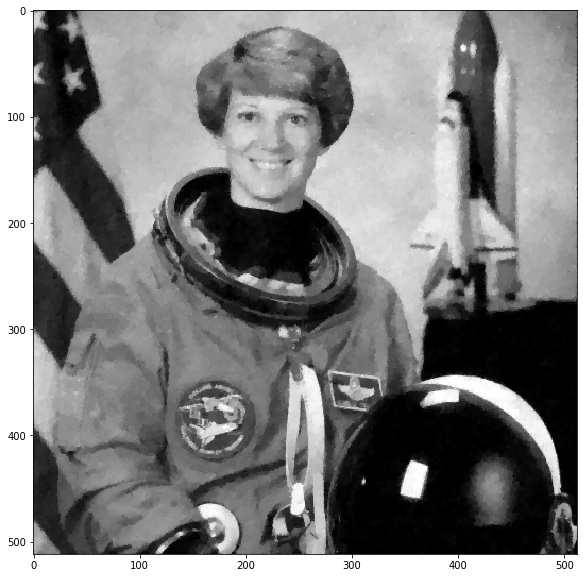

error rate = 0.01986367753027283


In [267]:
# write your code here

start = time.time()
x_min, list_svt_accel = accel_gradient(z_noisy, epsilon, lambda_, max_iterations, miu, lip_constant, z_noisy)
error = (1/n**2)*norm(x_min-img.flatten('F'),2)
end = time.time()
duration = end-start
print("running time: "+str(duration))

x_min = np.reshape(x_min, (n,n), order="F")
plt.figure(1, figsize=(10, 10))
plt.imshow(x_min, cmap='gray', vmin=0, vmax=255)
plt.show()
print("error rate = "+str(error))

## Question 5 (10 marks): in Q4 you were asked to implement accelerated gradient by using constant step-sizes $1/L.$ However, computing the Lipschitz constant might take a lot of time and it often results in slow convergence because the step-sizes are too small. Below I give you a practical accelerated method that does not require knowing the Lipschitz constant. The step-sizes $$\alpha_k$$ in this algorithm can be computed using Armijo line-search. Implement this algorithm for the Total-Variation denoising problem. Use the pseudo-Huber function to smooth the problem. 

Step 1) Choose an $x_0$ and set $y_1=x_0$, $t_1=1$.

Step 2) Repeat the following steps until $\|\nabla f(x_k)\|_2\le \epsilon$

Step 3) Compute $\alpha_k$ using Armijo line-search. Armijo line-search should be measured at $y_k-\alpha_k \nabla f(y_k)$ (as the next point) and $y_k$ (as the current point).

Step 4) Set $$x_{k}=y_k - \alpha_k \nabla f(y_k)$$

Step 5) Set $$t_{k+1}=\frac{1 + \sqrt{1+4t_k^2}}{2}$$

Step 6) Set $$y_{k+1}=x_k + \frac{t_k-1}{t_{k+1}}(x_k-x_{k-1})$$

Reference: this algorithm is given in "A Fast Iterative Shrinkage-Thresholding Algorithm for Linear Inverse Problems" by A. Beck and M. Teboulle.
===================== 

In [268]:
# Write your code here
def accel_gradient_armijo(x0, epsilon, lambda_, max_iterations, gamma, miu, z_noisy):
    t_kplus1 = 1
    y_k = x0
    x_k = x0
    
    t_k = t_kplus1
    x_kminus1 = x_k
    grad_svt = gradient_stv(x_k, miu, lambda_, z_noisy)
    list_svt = []
    list_svt.append(smooth_total_variation(x_k, miu, lambda_, z_noisy))
    i=1
                      
    while i < max_iterations:
        if norm(grad_svt, 2) <= epsilon: break

        alpha_k = line_search_armijo(y_k, miu, lambda_, gamma, z_noisy)
        
        x_k = y_k - alpha_k * gradient_stv(y_k, miu, lambda_, z_noisy)
        list_svt.append(smooth_total_variation(x_k, miu, lambda_, z_noisy))
        grad_svt = gradient_stv(x_k, miu, lambda_, z_noisy)
        
        t_kplus1 = (1+(1+4*(t_kplus1**2))**(0.5))/2
        y_k = x_k + ((t_k-1)/t_kplus1)*(x_k-x_kminus1)
        x_kminus1 = x_k
        t_k = t_kplus1
#         print("iterations: "+str(i))
        i+=1
        
    return x_k, list_svt, i

## Call the practical accelerated gradient to denoise the image. Use the same $\lambda$ and $\mu$ that you used in Q1.

running time: 15.407113790512085


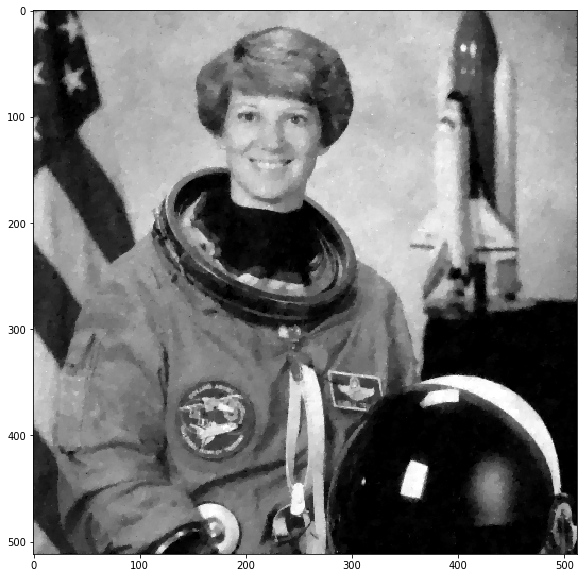

error rate = 0.019593867993852408


In [269]:
# Write your code here

start = time.time()
x_min, list_svt_accel_armijo, iter_ = accel_gradient_armijo(z_noisy, epsilon, lambda_, max_iterations, gamma, miu, z_noisy)
error = (1/n**2)*norm(x_min-img.flatten('F'),2)
end = time.time()
duration = end-start
print("running time: "+str(duration))

x_min = np.reshape(x_min, (n,n), order="F")
plt.figure(1, figsize=(10, 10))
plt.imshow(x_min, cmap='gray', vmin=0, vmax=255)
plt.show()
print("error rate = "+str(error))

## Question 6 (5 marks): Compare all the methods that you implemented above. Make a plot where in the y-axis is the value of the smoothed objective function and in the x-axis the number of iterations. Compare the methods using the same $\lambda$ and $\mu$ that you used in Q1.

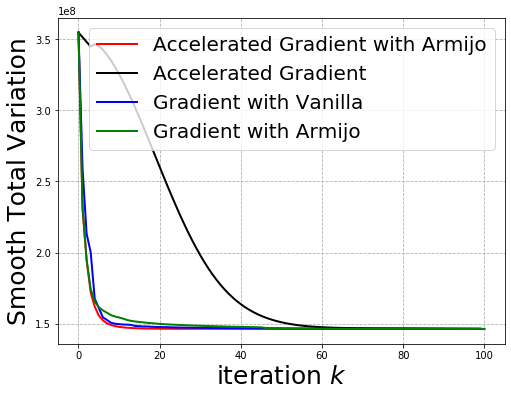

In [270]:
# Write your code here.
fig = plt.figure(figsize=(8, 6))
plt.plot(list_svt_accel_armijo, label=("Accelerated Gradient with Armijo"), linewidth=2.0, color ="red")
plt.plot(list_svt_accel, label=("Accelerated Gradient"), linewidth=2.0, color ="black")
plt.plot(list_svt_vanilla, label=("Gradient with Vanilla"), linewidth=2.0, color ="blue")
plt.plot(list_svt_armijo, label=("Gradient with Armijo"), linewidth=2.0, color ="green")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Smooth Total Variation", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

## Question 7 (8 marks): Illustrate the trade-off between the number of iterations and the smoothing parameter $\mu$ for gradient descent with Armijo line-search and accelerated gradient with Armijo line-search. Do this by plotting the number of iterations (y-axis) vs magnitude of parameter $\mu$ (x-axis in ascending order). Start from a small $\mu$ and increase it gradually. Plot the result for both methods in the same plot. Use appropriate legends for the plot.

In [271]:
# Write your code here.
armijo_test = []
accel_armijo_test = []

for r in range(80):
    x_min_, list_svt_armijo, iter_armijo = gradient_descent(z_noisy, epsilon, lambda_, max_iterations, gamma, miu, z_noisy)
    x_min, list_svt_accel_armijo, iter_accel_armijo = accel_gradient_armijo(z_noisy, epsilon, lambda_, max_iterations, gamma, miu, z_noisy)
    armijo_test.append(iter_armijo)
    accel_armijo_test.append(iter_accel_armijo) 
    miu+=1

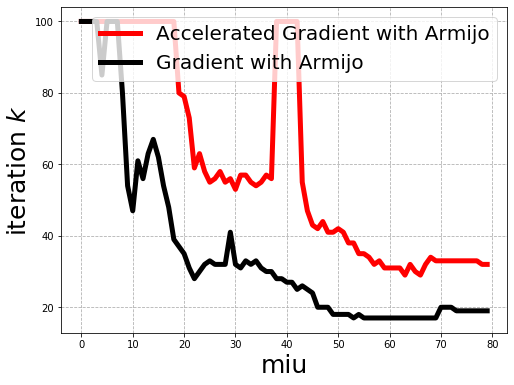

In [272]:
fig = plt.figure(figsize=(8, 6))
plt.plot(accel_armijo_test, label=("Accelerated Gradient with Armijo"), linewidth=5.0, color ="red")
plt.plot(armijo_test, label=("Gradient with Armijo"), linewidth=5.0, color ="black")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("miu", fontsize=25)
plt.ylabel("iteration $k$", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

## Mathematical Questions

## Question 8 (5 marks): Derive a smooth approximation (Huber function) of the L1-norm using the convex conjugate of the L1-norm and the distance function $$d(y)=\frac{1}{2}\|y\|_2^2.$$

## Question 9 (7 marks): Derive the pseudo-Huber function using the convex conjugate of the L1-norm.  To derive the pseudo-Huber use the distance function $$d(y)=\sum_{i=1}^n 1 - \sqrt{1-y_i^2}$$ with domain $$|y_i|\le 1 \ \ \forall i.$$

## Question 10 (3 marks): Show that the pseudo-Huber function is convex and not strongly-convex.

## Question 11 (7 marks): If the convex conjugate of $f$ is strongly-convex with compact convex domain then $$\max_{y \in \mbox{dom} \ f^*} x^Ty - f^*(y)$$ has a unique maximizer. Assume that $f$ is convex and show that  $$\nabla f(x) =\mbox{argmax}_{y \in \mbox{dom} \ f^*} x^Ty - f^*(y).$$ Hint: one approach to solve this is to lower and upper bound $f$ and then use the definition of directional derivative.

## Question 12 (7 marks): Prove that if the convex conjugate of $f$ is $\delta$-strongly-convex, then $\nabla f(x)$ is Lipschitz continuous with Lipschitz constant $1/\delta.$

## Question 13 (8 marks):  Assume that the domain of the convex conjugate satisfies $$\mbox{dom} \ f^* \subseteq \mathbb{R}^n.$$ and it is closed and bounded. Also, assume that $f$ is convex. You are given a continuous distance function $d(y)$ where its domain satisfies $$\mbox{dom} \ f^* \subseteq \mbox{dom} \ d .$$ Prove that $$f(x) - \mu D \le f_\mu(x) \le f(x),$$ where $D$ has to be bounded and $f_\mu(x)$ is the smooth approximation of $f$. See slides 54-57 in Lecture07and08 on piazza. Hint: you will need the Weierstrass extreme value theorem to show that $D$ is bounded.

## ## Question 14 (8 marks): We proved that for any convex function with Lipschitz continuous gradient there exists and estimate sequence. Show that for an estimate sequence we have that $$f(x_k) - f^* = \mathcal{O}\left(\frac{1}{k^2}\right)$$

## Question 15 (5 marks): Obtain the convergence rate and iteration complexity for the accelerated method for strongly-convex functions with Lipschitz continuous gradient.